**Table of contents**<a id='toc0_'></a>    
- [Solving for the stationary equilibrium in the HANC model](#toc1_)    
  - [Obtain the policy function with EGM](#toc1_1_)    
  - [Obtain the distribution using the histogram method](#toc1_2_)    
  - [Obtain aggregate hh variables using policies and the distribution](#toc1_3_)    
  - [Put everything together: solve for the steady-state in GE](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [48]:
import numpy as np
import numba as nb 
from consav.linear_interp import interp_1d_vec
from EconModel import jit
from HANCModel import HANCModelClass
import matplotlib.pyplot as plt
from consav.grids import equilogspace
from consav.markov import log_rouwenhorst

These notes are inspired by and draw upon the lecture notes of Matthew Rognlie, (available at this [link](https://github.com/shade-econ/nber-workshop-2023/tree/main)) which served as the original reference. I gratefully acknowledge his work and contribution as the foundation for this material.

# <a id='toc1_'></a>[Solving for the stationary equilibrium in the HANC model](#toc0_)

This notebook explains how to solve for the stationary equilibrium in the HANC model without the use of the GEModelTools. 

First, let us create a class that contains the necessary parameters to solve the model. 

In [49]:
class Parameters:
    def __init__(self):
        # preferences
        self.beta = 0.966
        self.sigma = 2.0
        
        # production
        self.alpha = 1/3
        self.delta = 0.008
        self.Gamma = 0.4
        
        # grids
        self.Na = 500
        self.a_min = 0.0
        self.a_max = 10_000.0 
        self.a_grid = equilogspace(self.a_min,self.a_max,self.Na)

        # income
        self.rho_z = 0.975
        self.sigma_psi = 0.7
        self.Nz = 7
        self.z_grid, self.z_trans,self.z_ergodic,_,_ = log_rouwenhorst(self.rho_z,self.sigma_psi,self.Nz)
        

par = Parameters()

## <a id='toc1_1_'></a>[Obtain the policy function with EGM](#toc0_)

The first step is to use the endogenous-grid method (EGM) to obtain the policy function for savings and consumption. 

The `solve_hh_backwards_one_step` implements one step of the EGM algorithm: given a guess on `vbeg_a`, the derivative of the value function, it returns policies for `a, c` and updates `vbeg_a`.

Lets's go in the detail about the EGM algorithm. Our goal is to obtain the policy functions $a'(a,z)$ and $c(a,z)$ for each point on the grids `a_grid` and `z_grid`. The standard method to do this if VFI: guess a value function $V(a,z)$, and iterate over the RHS of the Bellman equation $V^n(a,z)=(\max_{a'}\{u(c)+\beta \mathbb{E}[V^{n-1}(a',z')]\} until $V^n(a,z)\approx V^{n-1}(a,z)$. The issue with this method is that for each point $(a,z)$ on our grids, we need to run an optimization algorithm (like the golden-search algorithm), which is costly. 

The endogenous grid-method of Caroll proposes to iterate over the Euler equation insteady. First, recall that the first-order condition of the problem writes $u'(c)=\beta W'(a',z)$ where $W(a',z)=\mathbb{E}_z[V(a',z')]$. Our first step is thus to define an initial guess for $V_a$. 

In [50]:
w = 1 
r = 0.05 
y = w*par.z_grid
c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis]  # implied guess on a'(a,z)=a
Va = (1+r)*c**(-par.sigma)
Wa = par.z_trans @ Va # Take expectation using matrix multiplication

Instead of fixing a grid over $a$, we now set a grid over $a'$. We can set use the FOC to obtain $c$ as a function of $a'$:
$c(a',z)=u'^{-1}[\beta W'(a',z)]$. 

In [51]:
Nz, Na = Wa.shape
a = np.zeros((Nz, Na))
c = np.zeros((Nz, Na)) 

# a. solve step
for i_z in range(Nz):
    ## i. get c(a',z)
    c_endo = (par.beta*Wa[i_z])**(-1/par.sigma)


We also know that, from the budget constraint, we must have
$$a'+c(a',z)=a(1+r)+wz.$$
Note that in this equation, $a'$ and $z$ are defined on their grids, and we also know $c(a',z)$. We can thus invert it to obtain
$$
a(a',z) = \frac{a'+c(a',z)-wz}{1+r}
$$ 
where $a(a',z)$ is the *endogenous grid* for assets, hence the name of the method.

We are reversing the problem: instead of finding the optimal $a'$ given states $(a,z)$, we are asking: what is the $a$ today that would make it optimal to choose $a'$, given the Euler equation? 

Of course, we are eventually interested in $a'(a,z)$. To do so, we can invert our function $a(a',z)$ by using interpolation on the grid `a_grid`. That is, we interpolate the function $a'(a_{endo},z)$ on the point $a_{grid}$ which gives us $a'(a,z)$. 

In [52]:
for i_z in range(Nz):
    # ii. compute m_endo = c(a',z) + a'
    a_endo = (c_endo + par.a_grid-par.z_grid[i_z]) / (1+r) # current consumption + end-of-period assets

    # iii. interpolation to fixed grid
    interp_1d_vec(a_endo,par.a_grid,par.a_grid, a[i_z]) # fill up the array a[i_z]

The last thing to note is that, due to the borrowing constraint, some points $a'(a,z)$ implied by the FOC are not feasible and violate the borrowing constraint. We just impose them by setting $a'(a,z)=0$. 

In [53]:
for i_z in range(Nz):
    a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint

We then can compute $c(a,z)$ as the residual, and use the envelope condition to update our guess on the derivative of the value function
$$Va^n=(1+r)c(a,z)^{-\sigma}$$
and compute the expectation using the Markov transition matrix.

In [54]:
for i_z in range(Nz):
    c[i_z] = (1+r)*par.a_grid + w*par.z_grid[i_z]-a[i_z]
RHS = (1+r)*c**(-par.sigma)
vbeg_a_new = par.z_trans @ RHS

We then put all of this in one function, and iterate until convergence.

In [55]:
def solve_hh_backwards_one_step(z_trans, z_grid, a_grid, sigma, beta, r, w, vbeg_a):

    Nz, Na = vbeg_a.shape
    a = np.zeros((Nz, Na))
    c = np.zeros((Nz, Na)) 
    
    # a. solve step
    for i_z in range(Nz):
    
        ## i. get c(a',z)
        c_endo = (beta*vbeg_a[i_z])**(-1/sigma)
        
        # ii. compute a_endo = (c(a',z) + a' - z) / (1+r)
        a_endo = (c_endo + a_grid-w*z_grid[i_z]) / (1+r) # current consumption + end-of-period assets

        # iii. interpolation to fixed grid
        #a[i_z] = np.interp(a_grid, a_endo, a_grid)
        interp_1d_vec(a_endo, a_grid, a_grid, a[i_z]) # fill up the array a[i_z]
        a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint
        c[i_z] = (1+r)*a_grid + w*z_grid[i_z] - a[i_z]

    # b. expectation step
    RHS = (1+r)*c**(-sigma)
    vbeg_a_new = z_trans @ RHS

    return c, a, vbeg_a_new


Then, for a given $r$, $w$, we can loop over this step until convergence, that is, until the `vbeg_a` we feed into the function is arbitrarily close to the `vbeg_a_new` that it outputs.

In [56]:
w = 2/3
r = 0.05 / 4

In [57]:
def egm_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    """ solve the EGM for the steady state """

    # a. initialize
    y = w*par.z_grid
    c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis] 
    Va = (1+r)*c**(-par.sigma)

    # b. iterate
    for it in range(max_iter):

        # i. solve backwards
        c, a, Va_new = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r, w, Va)

        # ii. check convergence
        error = np.max(np.abs(Va - Va_new))
        if verbose:
            print(error)
        if error < tol:
            break

        Va = Va_new.copy()

    return c, a, Va_new

c, a, Va = egm_ss(r, w, par, verbose = True)


2470161070.787182
334025002.9307101
279549181.43693745
226232737.7605555
177898906.01208925
136251539.30274844
101658154.04185534
73714055.22786689
51632998.27584529
34497169.186932564
21402788.815830946
11534659.002521038
4741834.9600676745
4354455.676583454
5076905.682318926
7835800.082513332
9746119.511870384
11024201.64925623
11834433.77913618
12300756.178935051
12516004.510663748
12549330.857082367
12452001.475713253
12261868.163713217
12006780.963325262
11707170.461088896
11377987.425679684
11030150.431213617
10671620.177485466
10308192.752479076
9944082.731876373
9582350.080592632
9225211.608192682
8874267.538021803
8530665.957471848
8195222.009853363
7868504.24142766
7550897.203298807
7242646.947071791
6943894.2191569805
6654698.825434446
6375057.664402485
6104918.217607737
5844188.773314714
5592746.292057753
5350442.560336351
5117109.090037584
4892561.054385424
4676600.360270977
4469018.472710848
4269598.848916292
4078119.013124466
3894352.3245863914
3718069.4872322083
3549039

That's it! We have obtains the policy functions for consumption and savings of the households at the steady state for a given $r$ and $w$ (i.e. in partial equilibrium). We can plot those for given $(a,z)$. 

As expected, the consumption function is a concave function of wealth, and the net-savings function is a decreasing function of wealth, crossing the 0 horizontal line (implying a buffer-stock behavior).

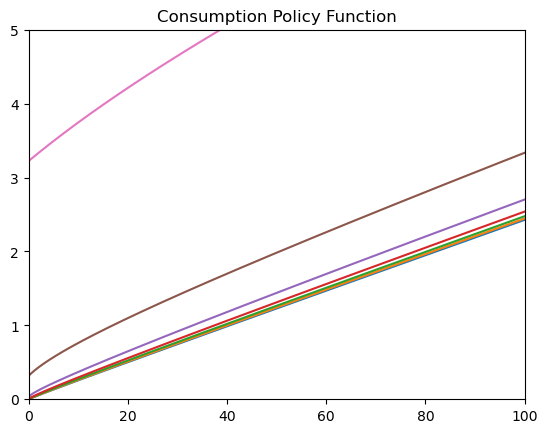

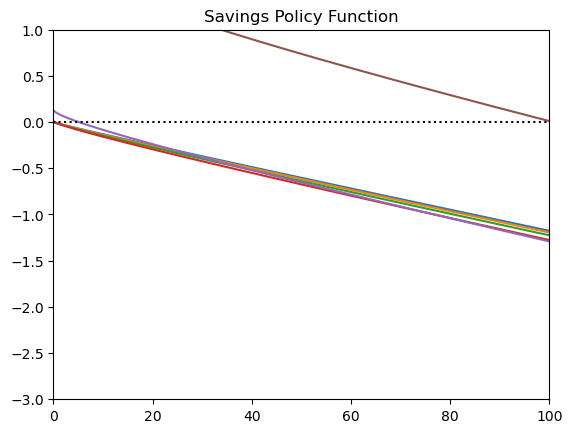

In [58]:
plt.plot(par.a_grid, c.T)
plt.xlim(0, 100)
plt.ylim(0, 5)
plt.title('Consumption Policy Function')
plt.show()

plt.plot(par.a_grid, (a-par.a_grid[np.newaxis,:]).T)
plt.plot(par.a_grid, np.zeros_like(par.a_grid), linestyle = ':', color = 'black')
plt.xlim(0, 100)
plt.ylim(-3, 1)
plt.title('Savings Policy Function')
plt.show()

## <a id='toc1_2_'></a>[Obtain the distribution using the histogram method](#toc0_)

The second part of this course is to compute the distribution. Our goal is to simulate the households in the economy in order to compute the distribution and the relevant aggregage variables. 

A first method to do this is the Monte-Carlo method: simulate $N$ households with initial conditions $(a_0,z_0)$ for $T$ periods using the policy functions and drawing shocks for each period. Because of the law of large number, if $T$ is large enough, the distribution will converge to its stationary distribution. However, this method is quite slow because for each $(i,t)$, we need to interpolate over the policy function and draw some new shocks for $z'$. It will also require a large $N$ for the law of large number to kick in.

Instead, we may use the histogram method (also sometimes called Young's method). The idea is to approximate a distribution $D(a,z)$ over our existing grids `a_grid`, `z_grid`. 

In [59]:
D = np.zeros((Nz, Na))
D[0] = 1.0 # initialize all households to be a z = z_min, a = a_min

One difficulty is that our policy function $a'(a,z)$ implies decisions that are most likely not on the grid for `a_grid`. For example, `a'[5,0]` is located between the points 16 and 17.

In [60]:
a_i = np.searchsorted(par.a_grid, a[5,0], side='right') -1

print(a[5,0])
print(par.a_grid[a_i])
print(par.a_grid[a_i+1])

1.777799439076865
1.7533347390167862
1.7963320621953467


To solve this problem, we will discretize our policy function, and use the 'lottery method' to distribute households to the points surrounding $a'(a,z)$. First, we obtain all the indexes on our grid such that, for all $a'(a,z)$, we find `a_i` where `a_grid[a_i]` is the point on the grid just below `a'` and `a_grid[a_i+1]` is the point just above. We can do this quickly using the `searchsorted` function from numpy.

In [61]:
a_i = np.searchsorted(par.a_grid, a, side='right') -1

print(a[5,0])
print(par.a_grid[a_i[5,0]])
print(par.a_grid[a_i[5,0]+1])

1.777799439076865
1.7533347390167862
1.7963320621953467


We will distribute households in this way:
`a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])`
if `a=a_grid[a_i]` we put a mass one on `a_grid[a_i]`. If `a=a_grid[a_i+1]`, we put a mass one on `a_grid[a_i+1]`. Otherwise, we put more weight on the point on the grid closer to $a'(a,z)$. 

In [62]:
a_pi = (par.a_grid[a_i+1] - a[5,0])/(par.a_grid[a_i+1] - par.a_grid[a_i])

We then write the `get_lottery` function that performs this discretization for all points on the grids.

In [63]:
def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a, side='right') - 1
    a_i = np.clip(a_i, 0, len(a_grid)-2)

    # step 2: implement (8) to obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi


We can now iterate over our discretize policy to compute the distribution next period, when we iterate once over the policy function.

In [64]:
@nb.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(e,a) of the mass to gridpoint i(e,a)
            Dend[e, a_i[e,a]] += a_pi[e,a]*D[e,a]
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e,a]+1] += (1-a_pi[e,a])*D[e,a]
            
    return Dend

To account for the idiosyncratic shock, we apply the transpose of our Markov matrix to the distribution.

In [65]:
def forward_iteration(D, z_trans, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return z_trans.T @ Dend

What does this do, in practice?

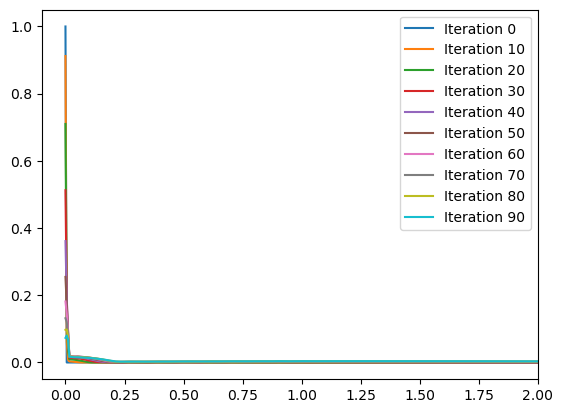

In [66]:
a_i, a_pi = get_lottery(a, par.a_grid)

D = np.zeros((Nz, Na))
D[0,0] = 1.0
for i in range(100):
    D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
    if i%10==0:
        plt.plot(par.a_grid, np.sum(D_new, axis=0), label=f'Iteration {i}')
        plt.xlim(-0.1, 2)
        plt.legend()
    D = D_new

We then iterate over this mapping until convergence!

In [67]:
def distribution_ss(a, par, tol=1E-10):
    a_i, a_pi = get_lottery(a, par.a_grid)

    # as initial D, use stationary distribution for s, plus uniform over a
    D = par.z_ergodic[:, np.newaxis] * np.ones_like(par.a_grid) / len(par.a_grid)

    # now iterate until convergence to acceptable threshold
    for _ in range(100_000):
        D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
        if np.max(np.abs(D_new - D)) < tol:
            return D_new
        D = D_new

In [68]:
D = distribution_ss(a, par)

One very important thing to understand is that, also the *distribution* is stationary, households move within this distribution at every period. However, because of the law of large numbers, each move perfectly compensate each other so that the distribution remain the same.

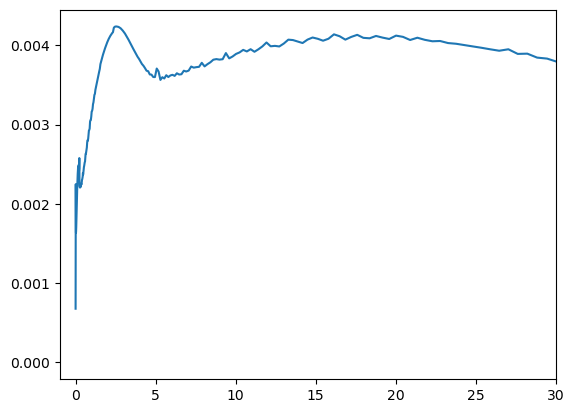

In [69]:
D_flat = np.sum(D, axis = 0)
plt.plot(par.a_grid, D_flat)
plt.xlim(-1, 30)
plt.show()

The last step is then to compute aggregate variables. We can do this easily by simply by integrating the policy functions over the distribution (i.e. summing, in our discrete world)

In [70]:
A = np.sum(a*D)
C = np.sum(c*D)

And that's it! We have seen how to:
1. Compute the policy functions of the households for a given $(r,w)$ 
2. And to compute the associated stationary distribution.
3. How to compute the aggregate variables of the household block

Now, let's move to solving the general equilibrium.

## <a id='toc1_3_'></a>[Obtain aggregate hh variables using policies and the distribution](#toc0_)

In [71]:
def household_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    c, a, Va = egm_ss(r, w, par, max_iter, tol, verbose) 
    D = distribution_ss(a, par)
    A = np.sum(D * a)
    C = np.sum(D * c) 
    return A, C, D, a, c, Va 


In [72]:
def firm(K, Gamma, par): 
    r = par.alpha * Gamma * K**(par.alpha-1) - par.delta
    Y = Gamma * K**par.alpha 
    w = (1-par.alpha) * Y  
    return r, w, Y

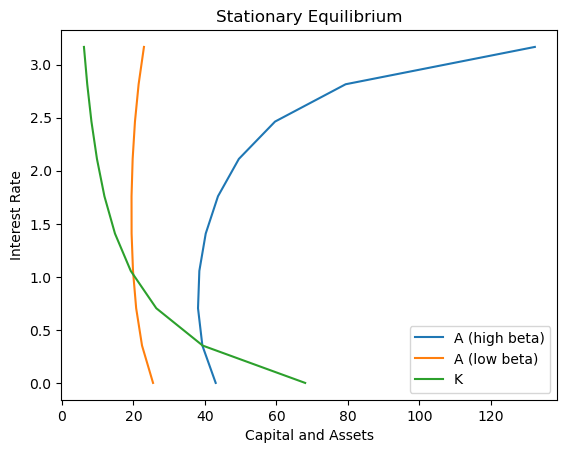

In [73]:
def asset_supply_r(r_vec, beta):
    par.beta = beta 
    Nr = len(r_vec)
    K_vec = ((r_vec+par.delta) / (par.alpha * par.Gamma))**(1/(par.alpha-1))
    Y = par.Gamma * K_vec**par.alpha
    w_vec = (1-par.alpha) * Y
    A_vec = np.zeros(Nr)
    for i, r in enumerate(r_vec):
        print
        A_vec[i], _, _, _, _, _  = household_ss(r_vec[i], w_vec[i], par) 
    return A_vec, K_vec

Nr = 10
r_vec = np.linspace(0.0, (1/par.beta-1)*0.9, Nr)
A_vec, K_vec = asset_supply_r(r_vec, par.beta)
A_vec_2, _ = asset_supply_r(r_vec , par.beta * 0.98)
plt.plot(A_vec, r_vec * 100, label = 'A (high beta)')
plt.plot(A_vec_2, r_vec * 100, label = "A (low beta)")
plt.plot(K_vec, r_vec * 100, label = 'K')
plt.xlabel('Capital and Assets')
plt.ylabel('Interest Rate')
plt.title('Stationary Equilibrium')
plt.legend()

## <a id='toc1_4_'></a>[Put everything together: solve for the steady-state in GE](#toc0_)

In [74]:
def find_ss(K, par):
    r, w, Y = firm(K, par.Gamma, par) 
    A, _, _, _, _, _  = household_ss(r, w, par) 
    print(A-K)
    return A-K

from scipy.optimize import brentq 

K = brentq(find_ss, 10.0, 50.0, args=(par,))
print('Equilibrium K = ', K)

9.733186353732691
-26.363502054643558
-0.7253342157887488
-0.06527538313238779
-0.0002928196243701109
-1.2339075183831483e-07
-7.432738868828892e-10
1.424439233232988e-09
1.378460012801952e-09
5.125606605815847e-10
5.310596407070989e-11
1.0135501327113161e-09
8.405613982631621e-10
6.884164349685307e-10
-2.490416761702363e-10
2.05755412707731e-10
Equilibrium K =  19.963846552124874
